In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy import constants

# Simulation of the planar three-body problem

## Theory
The newtonian equations for set of, in our case, three masses is given by 
\begin{equation}
\frac{d^2 \vec{r}_i}{d t^2}=\sum_{j \neq i=1}^{3} \frac{G m_j}{r_{i j}^3} \vec{r}_{i j}
\end{equation}
All calculations are based on the specific initial conditions introduced by the following papers:

https://arxiv.org/pdf/1709.04775.pdf
https://arxiv.org/pdf/1303.0181.pdf

We consider a planar three-body system with unequal masses ($m_1=m_2 \neq m_3$),zero angular momentum in the case of $G=1$ and the initial conditions
\begin{equation}
\left\{\begin{array}{l}\boldsymbol{r}_1(0)=\left(x_1, x_2\right)=-\boldsymbol{r}_2(0), \quad \boldsymbol{r}_3(0)=(0,0) \\ \dot{\boldsymbol{r}}_1(0)=\dot{\boldsymbol{r}}_2(0)=\left(v_1, v_2\right), \quad \dot{\boldsymbol{r}}_3(0)=-\frac{m_1+m_2}{m_3} \dot{\boldsymbol{r}}_1(0)\end{array}\right.
\end{equation}
Furthermore the paper introduces the transformations
\begin{equation}
\boldsymbol{r}_i^{\prime}\left(t^{\prime}\right)=\boldsymbol{r}_i(t), \quad \boldsymbol{v}_i^{\prime}\left(t^{\prime}\right)=\alpha \boldsymbol{v}_i(t), t^{\prime}=t / \sqrt{\alpha}, \quad m_i^{\prime}=\alpha^2 m_i,
\end{equation}
with an arbitrary $\alpha>0$. The calculations require the newtonian equations to be dimensionless. To meet our purpose to simulate the movement of real celestial bodies, we can explicitly calculate $\alpha$. The newtonian equations shall have the new form
\begin{equation}
\frac{d^2 \vec{r}_i^{\prime}}{d t^{\prime 2}}=\sum_{j \neq i=1}^{3} \frac{m_j^{\prime}}{r_{i j}^{\prime 3}} \vec{r}_{i j}^{\prime}
\end{equation}
The mass transforms $m_i^{\prime}=\alpha^2 m_i$ for $G=1$ and $L=1$, where $M$ is the characteristic mass and $L$ is the characteristic length. But as $G=6.67 \times 10^{-11}$ and $L$ is arbitrary, we get the transformation:
\begin{equation}
\frac{d^2 \vec{r}_i^{\prime}}{d t^{\prime 2}}=G\sum_{j \neq i=1}^{3} \frac{(\alpha^{\prime})^2 m_j}{r_{i j}^{3}} \vec{r}_{i j}=\alpha^2\sum_{j \neq i=1}^3 \frac{m_j}{r_{i j}^3} \vec{r}_{i j}=\frac{L^3}{GM}\sum_{j \neq i=1}^3 \frac{ m_j}{r_{i j}^3} \vec{r}_{i j}=\sum_{j \neq i=1}^{3} \frac{m_j^{\prime}}{r_{i j}^{\prime 3}} \vec{r}_{i j}^{\prime}
\end{equation}

One can identify $\alpha^2$ as $\frac{L^3}{GM}$. Taking $\alpha$ splitting it to the corresponding quantities, we get:
\begin{equation}
\vec{r}_i^{\prime}=\vec{r}_i / L\hspace{1.5cm}\vec{r}_{i j}^{\prime}=\vec{r}_{i j} / L
\end{equation}
\begin{equation}
m_i^{\prime}=m_i / M
\end{equation}
\begin{equation}
t^{\prime}=t \sqrt{G M / L^3}
\end{equation}

As the newtonian equations are second order ODE's, python is not able to solve them directly, we need to transform them into to coupled first oder ODE's:
\begin{equation}
\frac{d^2 y}{d t^2}=F\left(y, \frac{d y}{d t}, t\right)
\end{equation}
\begin{equation}
\begin{gathered}
\frac{d y}{d t}=v_y \\
\frac{d v_y}{d t}=F\left(y, v_y, t\right)
\end{gathered}
\end{equation}

We then get a system of first order ODE's that we can solve.

As mentioned above the paper sets specific initial conditions for those periodic orbits, those are:
- $x_1=-1$, $x_2=1$ and $x_3=0$
- $y_1=y_2=y_3=0$
- $v_1=v_{x1}=v_{x2}$ and $v_{x3}=-2v_1/m_3$
- $v_2=v_{y1}=v_{y2}$ and $v_{y3}=-2v_1/m_3$

In [2]:
v1 = 0.08058
v2 = 0.58884
m3 = 1

m1 = 1
m2 = 1
x1_0 = -1
x2_0 = 1
x3_0 = 0
y1_0, y2_0, y3_0 = 0, 0, 0
vx1_0 = v1
vx2_0 = v1
vx3_0 = -2*v1/m3
vy1_0 = v2
vy2_0 = v2
vy3_0 = -2*v2/m3

Now we consider the system
\begin{equation}
\vec{R}=\left(x_1, y_1, x_2, y_2, x_3, y_3, v_{x 1}, v_{y 1}, v_{x 2}, v_{y 2}, v_{x 3}, v_{y 3}\right)
\end{equation}
we want to solve for.
In order to solve this problem, we need to take the derivative of $\vec{R}$ with respect to $t$, which gives us:
\begin{equation}
\vec{R}=\left(v_{x 1}, v_{y 1}, v_{x 2}, v_{y 2}, v_{x 3}, v_{y 3}, \frac{d^2 \vec{r}_{x1}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{y1}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{x2}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{y2}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{x3}^{\prime}}{d t^{\prime 2}}, \frac{d^2 \vec{r}_{y3}^{\prime}}{d t^{\prime 2}}\right)
\end{equation}

In [3]:
def dR_dt(t, R):
    x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3 = R
    r12 = np.sqrt((x2-x1)**2+(y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2+(y3-y1)**2)
    r23 = np.sqrt((x2-x3)**2+(y2-y3)**2)
    return [vx1, vy1, 
            vx2, vy2,
            vx3, vy3,
            m2/(r12**3)*(x2-x1)+m3/(r13**3)*(x3-x1), #m1
            m2/(r12**3)*(y2-y1)+m3/(r13**3)*(y3-y1),
            m1/(r12**3)*(x1-x2)+m3/(r23**3)*(x3-x2), #m2
            m1/(r12**3)*(y1-y2)+m3/(r23**3)*(y3-y2),
            m1/(r13**3)*(x1-x3)+m2/(r23**3)*(x2-x3), #m3
            m1/(r13**3)*(y1-y3)+m2/(r23**3)*(y2-y3)]

In [4]:
t = np.linspace(0, 30, 8000)

In [5]:
y0 = [x1_0, y1_0, x2_0, y2_0, x3_0, y3_0, vx1_0, vy1_0, vx2_0, vy2_0, vx3_0, vy3_0]
t_span = (0, 30)

In [6]:
sol = solve_ivp(dR_dt, t_span, y0=y0, method='DOP853', t_eval=t, rtol=1e-13, atol=1e-16)

In [7]:
t = sol.t
x1 = sol.y[0]
y1 = sol.y[1]
x2 = sol.y[2]
y2 = sol.y[3]
x3 = sol.y[4]
y3 = sol.y[5]

vx1 = sol.y[6]
vy1 = sol.y[7]
vx2 = sol.y[8]
vy2 = sol.y[9]
vx3 = sol.y[10]
vy3 = sol.y[11]

In [8]:
# plt.plot(t, x1)

In [9]:
def angular_momentum(x, y, vx, vy, m):
    r = np.column_stack((x,y))
    v = np.column_stack((vx, vy))
    return m * np.cross(r, v)

(0.0, 5.0)

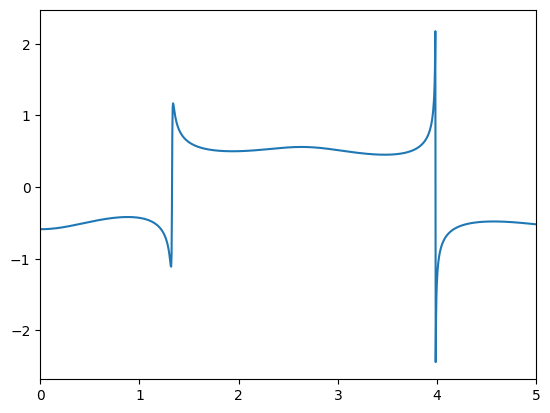

In [10]:
plt.plot(t, angular_momentum(x1, y1, vx1, vy1, m1))
# plt.plot(t, angular_momentum(x2, y2, vx2, vy2, m2))
# plt.plot(t, angular_momentum(x3, y3, vx3, vy3, m3))
total_mom = angular_momentum(x1, y1, vx1, vy1, m1) + angular_momentum(x2, y2, vx2, vy2, m2) + angular_momentum(x3, y3, vx3, vy3, m3)
# plt.plot(t, total_mom)
plt.xlim(0, 5)

In [11]:
L1 = angular_momentum(x1, y1, vx1, vy1, m1)
L2 = angular_momentum(x2, y2, vx2, vy2, m2)
L3 = angular_momentum(x3, y3, vx3, vy3, m3)
L_tot = angular_momentum(x1, y1, vx1, vy1, m1) + angular_momentum(x2, y2, vx2, vy2, m2) + angular_momentum(x3, y3, vx3, vy3, m3)

In [12]:
G = constants.G
L = 1.495978707*1e11 #distance earth-sun in m
M = 1.98892*1e30 #mass sun in kg

alpha = L**3/(G*M)

In [13]:
factor = np.sqrt(alpha) / (60*60 * 24* 365.25) * np.diff(t)[0]
factor1 = np.sqrt(alpha) / (60*60 * 24* 365.25)

In [14]:
def formatter(years_decimal, pos):
    converted_decimal = years_decimal * factor1
    yearindays = 365.25
    full_years = int(converted_decimal)
    days_decimal = (converted_decimal - full_years) * yearindays
    full_days = int(days_decimal)
    return f"{full_years}a {full_days}d"

In [15]:
def convert_years(years_decimal):
    yearindays = 365.25
    full_years = int(years_decimal)
    days_decimal = (years_decimal - full_years) * yearindays
    full_days = int(days_decimal)
    return full_years, full_days

In [16]:
from matplotlib.ticker import FuncFormatter
from matplotlib.animation import FuncAnimation
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from animation import HaloPoint, TrajectoryOpt, ProgressWriter, ProgressPillowWriter
matplotlib.use('QT5Agg')
%matplotlib qt


def update_L(frame):
    momentum1.set_data(t, L1, frame)
    momentum2.set_data(t, L2, frame)
    momentum3.set_data(t, L3, frame)
    momentum4.set_data(t, L_tot, frame)
    axis.set_data(t, np.full(len(t), -3), frame)
    artists = (momentum1.get_artists() +
               momentum2.get_artists() +
               momentum3.get_artists() +
               momentum4.get_artists() +
               axis.get_artists())

    def alpha_func(x):
            mid_point = 0.2  # point where the decay begins relative to x_range
            steepness = 10  # steepness of decay
            normalized_position = (x - x_left) / x_range
            return 1 - 1 / (1 + np.exp(steepness * (normalized_position - mid_point)))

    tolerance = 1e-2

    if t[frame]>repeat_length:
        ax.set_xticks(np.arange(0, round(t[-1]), 1))

        ax.set_xlim(t[frame] - repeat_length, t[frame])

        x_left, x_right = ax.get_xlim()
        x_range = x_right - x_left
        
        for ticklabel, tickpos, tick in zip(ax.xaxis.get_ticklabels(), ax.xaxis.get_majorticklocs(), ax.xaxis.get_major_ticks()):
            alpha_value = alpha_func(tickpos)
            ticklabel.set_alpha(alpha_value)
            tick.tick1line.set_alpha(alpha_value)
    else:
         ax.set_xlim(0,repeat_length)
         if np.abs(t[frame] - round(t[frame])) < tolerance:
            ax.set_xticks([i for i in np.arange(0, round(t[frame]) + 1, 1)])
         x_left, x_right = 0, t[frame + 1]
         x_range = x_right - x_left
         for ticklabel, tickpos, tick in zip(ax.xaxis.get_ticklabels(), ax.xaxis.get_majorticklocs(), ax.xaxis.get_major_ticks()):
            alpha_value = alpha_func(tickpos)
            ticklabel.set_alpha(alpha_value)
            tick.tick1line.set_alpha(alpha_value)

    ax.xaxis.set_major_formatter(FuncFormatter(formatter))
    
    return artists

def update(frame):
    text.set_text(f'$T = {convert_years(frame*factor)[0]}\,a\;{convert_years(frame*factor)[1]}\,d$ ')
    point1.set_data(x1[frame], y1[frame])    
    point2.set_data(x2[frame], y2[frame])
    point3.set_data(x3[frame], y3[frame])
    trajectory1.set_data(x1, y1, frame)
    trajectory2.set_data(x2, y2, frame)
    trajectory3.set_data(x3, y3, frame)
    artists = (point1.get_artists() +
               point2.get_artists() +
               point3.get_artists() +
               trajectory1.get_artists() +
               trajectory2.get_artists() +
               trajectory3.get_artists())
    return artists + [text]

dpi = 300
width = 3840/dpi
height = 2160/dpi

# fig, ax = plt.subplots(figsize=(width, height))
# fig, ax = plt.subplots(figsize=(6, 6))

fig, (ax1, ax) = plt.subplots(1, 2, figsize=(width, height))

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

repeat_length = 5

ax.set_xlim(0, repeat_length)
ax.set_ylim(-3,3)
ax.grid(False)
# ax.axis('off')
# fig.patch.set_facecolor('black')
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['bottom'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)
# ax.spines['left'].set_bounds(-.05, .05)
# ax.spines['bottom'].set_bounds(-0, 0)

ax.tick_params(axis='x', colors='white', direction='in')
ax.tick_params(axis='y', colors='white', direction='in')
ax.set_yticks([0])
tick_length = 0.008  # tick length
ax.axhline(0, xmin=0, xmax=tick_length, color='white', zorder=10, linewidth=.5)  # tick at y=0
plt.title(label='Angular momentum', loc='center', color='white', fontsize=16)
# ax.text(-0.1, 0, '0', color='white', va='center', zorder=10)

datarange1 = np.sum(t <= repeat_length)  #points of trajectory
color_decay = 1

momentum1 = TrajectoryOpt(ax, 1, 1.5, datarange=datarange1, color1='blue', color2='dodgerblue', alpha1=.1, alpha2=.05, alpha3=.025)
momentum2 = TrajectoryOpt(ax, 1, 1.5, datarange=datarange1, color1='orangered', color2='darkorange', alpha1=.1, alpha2=.05, alpha3=.025)
momentum3 = TrajectoryOpt(ax, 1, 1.5, datarange=datarange1, color1='gold', color2='yellow', alpha1=.15, alpha2=.05, alpha3=.025)
momentum4 = TrajectoryOpt(ax, 1, 1.5, datarange=datarange1, color1='green', color2='lime', alpha1=1, alpha2=.4, alpha3=.2)
axis = TrajectoryOpt(ax, 2, 1.5, datarange=datarange1, color1='darkgrey', color2='white', alpha1=1, alpha2=0, alpha3=0)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.grid(False)
ax1.axis('off')
fig.patch.set_facecolor('black')

datarange = 400  #points of trajectory
# color_decay = 1

text = ax1.text(0, 1.6, 'T', fontsize=16, backgroundcolor='black', ha='center', c='white')
name = ax1.text(0, 2, 'I.B.7 dragonfly', fontsize=16, backgroundcolor='black', ha='center', c='white')
point1 = HaloPoint(ax1, 1, .6, color1='dodgerblue')
point2 = HaloPoint(ax1, 1, .6, color1='darkorange')
point3 = HaloPoint(ax1, 1, .6, color1='yellow')
trajectory1 = TrajectoryOpt(ax1, 1, 1.5, datarange=datarange, color1='blue', color2='dodgerblue', alpha1=1, alpha2=.4, alpha3=.2)
trajectory2 = TrajectoryOpt(ax1, 1, 1.5, datarange=datarange, color1='orangered', color2='darkorange', alpha1=1, alpha2=.4, alpha3=.2)
trajectory3 = TrajectoryOpt(ax1, 1, 1.5, datarange=datarange, color1='gold', color2='yellow', alpha1=1, alpha2=.4, alpha3=.2)

def update_both(frame):
    artists = (update(frame) + 
               update_L(frame))
    return artists

# ani = FuncAnimation(ax.figure, update_L, frames=len(L1), blit=True, interval=1)
# ani1 = FuncAnimation(ax1.figure, update, frames=len(x1), blit=True, interval=1)
ani = FuncAnimation(fig, update_both, frames=len(L1), blit=False, interval=1)
plt.show()

# progress_writer = ProgressWriter(total_frames=len(x1)//2, fps=120, extra_args=['-c:v', 'h264_videotoolbox', '-s', '3840x2160'], bitrate=1800)
# ani.save('test1.mp4', writer=progress_writer)

After having solved the problem we still need to transform back the time, while the other quantities remain invariant.

In [17]:
# G = constants.G
# L = 1.495978707*1e11 #distance earth-sun in m
# M = 1.98892*1e30 #mass sun in kg
# 
# alpha = L**3/(G*M)

In [18]:
# factor = np.sqrt(alpha) / (60*60 * 24* 365.25) * np.diff(t)[0]

# Animation of the trajectories

In [19]:
import matplotlib
from matplotlib.animation import FuncAnimation
from animation import HaloPoint, TrajectoryOpt, ProgressWriter, ProgressPillowWriter
# matplotlib.use('QT5Agg')

In [20]:
# %matplotlib qt

In [21]:
# def update(frame):
#     text.set_text(f'$T = {convert_years(frame*factor)[0]}\,a\;{convert_years(frame*factor)[1]}\,d$ ')
#     point1.set_data(x1[frame], y1[frame])    
#     point2.set_data(x2[frame], y2[frame])
#     point3.set_data(x3[frame], y3[frame])
#     trajectory1.set_data(x1, y1, frame)
#     trajectory2.set_data(x2, y2, frame)
#     trajectory3.set_data(x3, y3, frame)
#     artists = (point1.get_artists() +
#                point2.get_artists() +
#                point3.get_artists() +
#                trajectory1.get_artists() +
#                trajectory2.get_artists() +
#                trajectory3.get_artists())
#     return artists + [text]
# 
# dpi = 300
# width = 3840/dpi
# height = 2160/dpi
# 
# fig1, ax1 = plt.subplots(figsize=(width, height))
# # fig, ax = plt.subplots(figsize=(6, 6))
# 
# plt.rcParams["font.family"] = "times"
# plt.rcParams["text.usetex"] = True
# 
# ax1.set_xlim(-2, 2)
# ax1.set_ylim(-2, 2)
# ax1.grid(False)
# ax1.axis('off')
# fig1.patch.set_facecolor('black')
# 
# datarange = 400  #points of trajectory
# color_decay = 1
# 
# text = plt.text(0, 1.6, 'T', fontsize=16, backgroundcolor='black', ha='center', c='white')
# name = plt.text(0, 2, 'I.A.2 butterfly II', fontsize=16, backgroundcolor='black', ha='center', c='white')
# point1 = HaloPoint(ax1, 1, .6, color1='dodgerblue')
# point2 = HaloPoint(ax1, 1, .6, color1='darkorange')
# point3 = HaloPoint(ax1, 1, .6, color1='yellow')
# trajectory1 = TrajectoryOpt(ax1, 1, 1.5, datarange=datarange, color1='blue', color2='dodgerblue', alpha1=1, alpha2=.4, alpha3=.2)
# trajectory2 = TrajectoryOpt(ax1, 1, 1.5, datarange=datarange, color1='orangered', color2='darkorange', alpha1=1, alpha2=.4, alpha3=.2)
# trajectory3 = TrajectoryOpt(ax1, 1, 1.5, datarange=datarange, color1='gold', color2='yellow', alpha1=1, alpha2=.4, alpha3=.2)
# # 
# # 
# ani1 = FuncAnimation(fig1, update, frames=len(x1), blit=True, interval=1)
# 
# plt.show()
# writer = ProgressPillowWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800, total_frames=110)

# progress_writer = ProgressWriter(total_frames=len(x1)//2, fps=120, extra_args=['-c:v', 'h264_videotoolbox', '-s', '3840x2160'], bitrate=1800)
# ani.save('butterfly2.mp4', writer=progress_writer)

In [22]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# 
# ani1 = FuncAnimation(fig, lambda frame: update(frame, ax1), frames=len(x1), blit=True, interval=1)
# ani2 = FuncAnimation(fig, lambda frame: update_L(frame, ax2), frames=len(x1), blit=False, interval=1)
# 
# plt.show()